<h1> Line of Balance </h>

<h4> By: Sean Yoon </h4>

<h3>0. Mock Data Generation</h3>

In this section, we will generate mock data for the Line of Balance (LOB) analysis. The mock data consists of 10 unique part_number and 5 unique line_number.

In [1]:
import csv, random, string
from collections import defaultdict

# ---------- Config ----------
NUM_PARTS   = 150
LINES       = [i for i in range(100, 131)]

# ---------- Part‑number helper ----------
def random_part():
    left  = ''.join(str(random.randint(1,9)) for _ in range(3))
    letter= random.choice(string.ascii_uppercase)
    mid   = ''.join(str(random.randint(1,9)) for _ in range(4))
    suf   = random.randint(1,15)
    return f"{left}{letter}{mid}-{suf}"

def make_unique_parts(n=NUM_PARTS):
    parts=set()
    while len(parts)<n:
        parts.add(random_part())
    return list(parts)

PARTS = make_unique_parts()

# ---------- Reusable qty helpers ----------
rand_demand  = lambda: random.randint(1,5)   # 1‑5 inclusive
rand_supply  = lambda lo,hi: random.randint(lo,hi)

# ---------- 1. Inventory ---------------
def generate_inventory(fn="Inventory.csv"):
    with open(fn,'w',newline='') as f:
        w=csv.writer(f); w.writerow(["part_number","qty"])
        for p in PARTS:
            w.writerow([p, rand_supply(25,45)])
    print("Generated",fn)

# ---------- 2. Company_Line_Demand  (random qty per column) ----------
def generate_boeing_line_demand(filename="Line_Demand.csv"):
    """
    For each part–line combination choose an independent random qty (1-5).
    Result: every column (line) gets its own value; rows are not constant.
    """
    rows = []
    for part in PARTS:
        for ln in LINES:
            qty = random.randint(1, 5)      # NEW: random for every column
            rows.append((part, ln, qty))

    # sort for readability: part then line
    rows.sort(key=lambda r: (r[0], r[1]))

    with open(filename, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["part_number", "line_number", "qty"])
        w.writerows(rows)

    print(f"Generated {filename}: random demand 1-5 per (part,line)")


# ---------- 3. Suppliers --------------
def generate_suppliers(fn="Supplier.csv"):
    with open(fn,'w',newline='') as f:
        csv.writer(f).writerows([
            ["supplier_id","name"],
            [1,"Supplier A"],
            [2,"Supplier B"],
            [3,"Supplier C"]
        ])
    print("Generated",fn)

# ---------- 4. Shipment Log -----------
def generate_shipment(fn="Supplier_Shipment.csv", rows=150):
    statuses = ["PACKING", "SHIPPED", "STAGED", "DELIVERED"]
    with open(fn, 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(["id","supplier_id","part_number","qty","status"])

        # --- guarantee one TRANSIT status per part ---
        idx = 1
        for part in PARTS:
            w.writerow([idx, 1, part, rand_supply(15,40),
                        random.choice(["PACKING","SHIPPED","STAGED"])])
            idx += 1

        # --- extra random rows to reach target ---
        for i in range(idx, rows+1):
            w.writerow([i, ((i-1)%3)+1, random.choice(PARTS),
                         rand_supply(15,40), random.choice(statuses)])
    print("Generated", fn)

# ---------- 5. Production Log ----------
def generate_production(fn="Supplier_Production_Status.csv", rows=150):
    statuses = ["FINAL_ASSEMBLY","SUBASSEMBLY","STAGED"]
    with open(fn, 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(["id","supplier_id","part_number","qty","status"])

        # --- guarantee one WIP status per part ---
        idx = 1
        for part in PARTS:
            w.writerow([idx, 1, part, rand_supply(15,40),
                        random.choice(["FINAL_ASSEMBLY","SUBASSEMBLY"])])
            idx += 1

        # --- extra random rows ---
        for i in range(idx, rows+1):
            w.writerow([i, ((i-1)%3)+1, random.choice(PARTS),
                         rand_supply(15,40), random.choice(statuses)])
    print("Generated", fn)

# ---------- Master runner -------------
def main():
    random.seed()                      # full randomness each run
    generate_inventory()
    generate_boeing_line_demand()
    generate_suppliers()
    generate_shipment()
    generate_production()

if __name__=="__main__":
    main()


Generated Inventory.csv
Generated Line_Demand.csv: random demand 1-5 per (part,line)
Generated Supplier.csv
Generated Supplier_Shipment.csv
Generated Supplier_Production_Status.csv


First, our line of balance will require databases from our company (Boeing) and suppliers. In the company database, we have two data tables: inventory table and demand table. Inventory table will consist of part number and quantity (qty) in stock. Demand table will consist of part number, line number, and quantity (qty) of each part required for each line. 


<h3>1. Environment Setup </h3>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h3>2. Data Preparation </h3>

Forming tables from the company database and supplier database, which are expected to be in CSV format, into dataframes, allowing to perform data manipulation and analysis using pandas.


In [3]:
# 1. Inventory data 
inventory_df = pd.read_csv("Inventory.csv")  # part_number | qty

# 2. Demand data per production line
demand_df = pd.read_csv("Line_Demand.csv")   # part_number | line_number | qty

# 3. Supplier data
supplier_df = pd.read_csv("Supplier.csv")    # supplier_id | name

# 4. Shipment data (used for WIP if status is PACKING or STAGED)
shipment_df = pd.read_csv("Supplier_Shipment.csv")      # id | supplier_id | part_number | qty | status

# 5. Production status log (used for WIP if status != STAGED)
production_df = pd.read_csv("Supplier_Production_Status.csv")       # id | supplier_id | part_number | qty | status


In [4]:
inventory_df.rename(columns={'qty': 'inventory'}, inplace=True)
demand_df.rename(columns={'qty': 'demand_qty'}, inplace=True)

To refrain confusion, we renamed 'qty' from inventory and demand tables to 'inventory' and 'demand_qty'.


<h3>3. Grouping 'Transit' and 'WIP'</h3>

In shipment and production data logs, we will sort statuses into 'Transit' and 'WIP' (Work In Progress) tables. Parts with 'PACKING', 'SHIPPED', and 'STAGED' are categorized as 'Transit', while 'FINAL_ASSEMBLY' and 'SUBASSEMBLY' are categorized as 'WIP'. This categorization helps in understanding the flow of parts through the production process.

In [5]:
shipment_df

,id,supplier_id,part_number,qty,status
0,1,1,564V7324-11,16,STAGED
1,2,1,251E6155-14,32,PACKING
2,3,1,937T1239-11,24,PACKING
3,4,1,948H6585-3,17,STAGED
4,5,1,434U4311-15,30,STAGED
...,...,...,...,...,...
145,146,1,693I7983-3,33,PACKING
146,147,1,366Y6481-2,30,PACKING
147,148,1,516H9244-8,17,PACKING
148,149,1,399H2854-8,17,STAGED


In [6]:
production_df

,id,supplier_id,part_number,qty,status
0,1,1,564V7324-11,38,FINAL_ASSEMBLY
1,2,1,251E6155-14,28,SUBASSEMBLY
2,3,1,937T1239-11,15,SUBASSEMBLY
3,4,1,948H6585-3,39,FINAL_ASSEMBLY
4,5,1,434U4311-15,22,SUBASSEMBLY
...,...,...,...,...,...
145,146,1,693I7983-3,35,FINAL_ASSEMBLY
146,147,1,366Y6481-2,18,SUBASSEMBLY
147,148,1,516H9244-8,30,SUBASSEMBLY
148,149,1,399H2854-8,31,SUBASSEMBLY


In [7]:
# Shipment
transit_df = shipment_df[shipment_df['status'] != 'DELIVERED'].groupby('part_number')['qty'].sum().reset_index(name='transit')

# Production
wip_df = production_df[production_df['status'] != 'STAGED'].groupby('part_number')['qty'].sum().reset_index(name='wip')

In [8]:
transit_df

,part_number,transit
0,117G2587-9,19
1,121F8636-5,34
2,122O2269-4,31
3,123Q7537-11,23
4,124K9644-11,20
...,...,...
145,992E5338-9,32
146,995R7695-2,36
147,996K2291-7,39
148,997C4188-10,27


In [9]:
wip_df

,part_number,wip
0,117G2587-9,36
1,121F8636-5,39
2,122O2269-4,38
3,123Q7537-11,23
4,124K9644-11,38
...,...,...
145,992E5338-9,38
146,995R7695-2,26
147,996K2291-7,23
148,997C4188-10,23


<h3>4. Merging Demand, Transit, and WIP to LoB DataFrame</h3>

In this stage, we will merge the demand, transit, and WIP dataframes into a single Line of Balance (LoB) dataframe. This will allow us to have a comprehensive view of the parts required for each line, their current status, and the quantities available.

In [10]:
# Demand
lob_df = demand_df.copy()
lob_df = lob_df.merge(inventory_df, on='part_number', how='left')
lob_df = lob_df.merge(transit_df, on='part_number', how='left')
lob_df = lob_df.merge(wip_df, on='part_number', how='left')
lob_df['inventory'] = lob_df['inventory'].fillna(0)
lob_df['transit'] = lob_df['transit'].fillna(0)
lob_df['wip'] = lob_df['wip'].fillna(0)

<h3>5. LoB Calculation & Visualization</h3>

In [11]:
# 1) initial supply
lob_df['initial_supply'] = lob_df['inventory'] + lob_df['transit'] + lob_df['wip']

# 2) sort & reset index
lob_df = lob_df.sort_values(['part_number','line_number'])
lob_df.reset_index(drop=True, inplace=True)

# 3) cumulative demand
lob_df['cum_demand'] = lob_df.groupby('part_number')['demand_qty'].cumsum()

# 4) remaining supply *before* each line
lob_df['prev_demand'] = lob_df.groupby('part_number')['cum_demand'].shift(fill_value=0)
lob_df['remaining_supply'] = lob_df['initial_supply'] - lob_df['prev_demand']

# 5) surplus *after* fulfilling this line
lob_df['surplus'] = lob_df['remaining_supply'] - lob_df['demand_qty']


In [12]:
lob_df

,part_number,line_number,demand_qty,inventory,transit,wip,initial_supply,cum_demand,prev_demand,remaining_supply,surplus
0,117G2587-9,100,3,35,19,36,90,3,0,90,87
1,117G2587-9,101,1,35,19,36,90,4,3,87,86
2,117G2587-9,102,1,35,19,36,90,5,4,86,85
3,117G2587-9,103,4,35,19,36,90,9,5,85,81
4,117G2587-9,104,1,35,19,36,90,10,9,81,80
...,...,...,...,...,...,...,...,...,...,...,...
4645,998U8479-15,126,1,41,35,32,108,83,82,26,25
4646,998U8479-15,127,5,41,35,32,108,88,83,25,20
4647,998U8479-15,128,1,41,35,32,108,89,88,20,19
4648,998U8479-15,129,3,41,35,32,108,92,89,19,16


<h4> Demand table </h4>

In [13]:
lob_df['line_number'] = lob_df['line_number'].astype(int)
pivot_demand = lob_df.pivot_table(index='part_number', columns='line_number', values='demand_qty', fill_value=0)
pivot_demand

line_number,100,101,102,103,104,105,106,107,108,109,...,121,122,123,124,125,126,127,128,129,130
part_number,,,,,,,,,,,,,,,,,,,,,
117G2587-9,3,1,1,4,1,4,5,1,2,2,...,5,1,5,1,3,5,4,2,4,2
121F8636-5,3,4,2,4,1,1,4,5,1,1,...,4,3,5,5,5,2,5,4,5,3
122O2269-4,1,2,1,2,2,4,2,5,5,3,...,2,5,2,5,2,2,4,3,5,2
123Q7537-11,2,2,4,3,5,2,3,2,3,4,...,3,1,1,5,2,5,2,5,3,5
124K9644-11,5,2,1,2,2,2,4,3,5,1,...,3,1,2,3,4,5,1,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992E5338-9,2,2,5,4,3,4,1,3,3,5,...,2,5,5,2,1,5,2,4,2,5
995R7695-2,5,1,4,3,1,5,3,4,4,3,...,1,5,2,3,5,5,1,3,5,5
996K2291-7,5,1,4,3,2,2,4,1,4,3,...,2,3,3,4,2,3,5,3,4,4


This is our visualization of the Line of Balance (LoB) analysis. We used matplotlib to create a color map that shows the status of each part in the production line. Green indicates that the demand of the line is met with the available inventory. Orange indicates that the demand is partially met, which the demand is greater than the inventory but could be met with the parts in transit. Yellow indicates that the demand is not met with the parts in inventory and transit but with parts in production (WIP). Red indicates that the demand is not met at all, meaning there are no parts available in inventory, transit, or WIP.

In [14]:
from pathlib import Path
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

# ------------------------------------------
# 1)  Collect
# ------------------------------------------
IMG_DIR = Path("lob_diagrams")

png_files = list(IMG_DIR.glob("*.png")) + list(IMG_DIR.glob("*.PNG"))
img_files = sorted(png_files)

if not img_files:
    raise FileNotFoundError("Nothing found in 'lob_diagrams/'!")

options = {p.stem: p for p in img_files}

# ------------------------------------------
# 2)  Widgets
# ------------------------------------------
PALETTE_SIZE = 1350              #  << palette side in pixels
dd  = widgets.Dropdown(options=options, description="Choose:")
out = widgets.Output()

def make_scroll_box(path: Path) -> widgets.Box:
    """Return a scrollable square palette with a white background."""
    img = Image.open(path).convert("RGBA")         # keep alpha if it exists

    # ── sandwich on white ─────────────────────────────────────────────
    if img.mode == "RGBA":                         # only if there's transparency
        white_bg = Image.new("RGB", img.size, (255, 255, 255))
        white_bg.paste(img, mask=img.split()[3])   # 3 = alpha channel
        img = white_bg                             # now opaque RGB
    # ------------------------------------------------------------------

    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    img_widget = widgets.Image(value=buf.getvalue(), format='png')

    return widgets.Box(
        [img_widget],
        layout=widgets.Layout(
            width = f"{PALETTE_SIZE}px",
            height= f"{PALETTE_SIZE}px",
            overflow_x = "auto",
            overflow_y = "auto",
            border="1px solid #888",
            background="white"       # white palette behind the image
        )
    )


def refresh(change=None):
    out.clear_output(wait=True)
    with out:
        display(make_scroll_box(dd.value))

dd.observe(refresh, names="value")
refresh()                       # initial render
display(widgets.VBox([dd, out]))


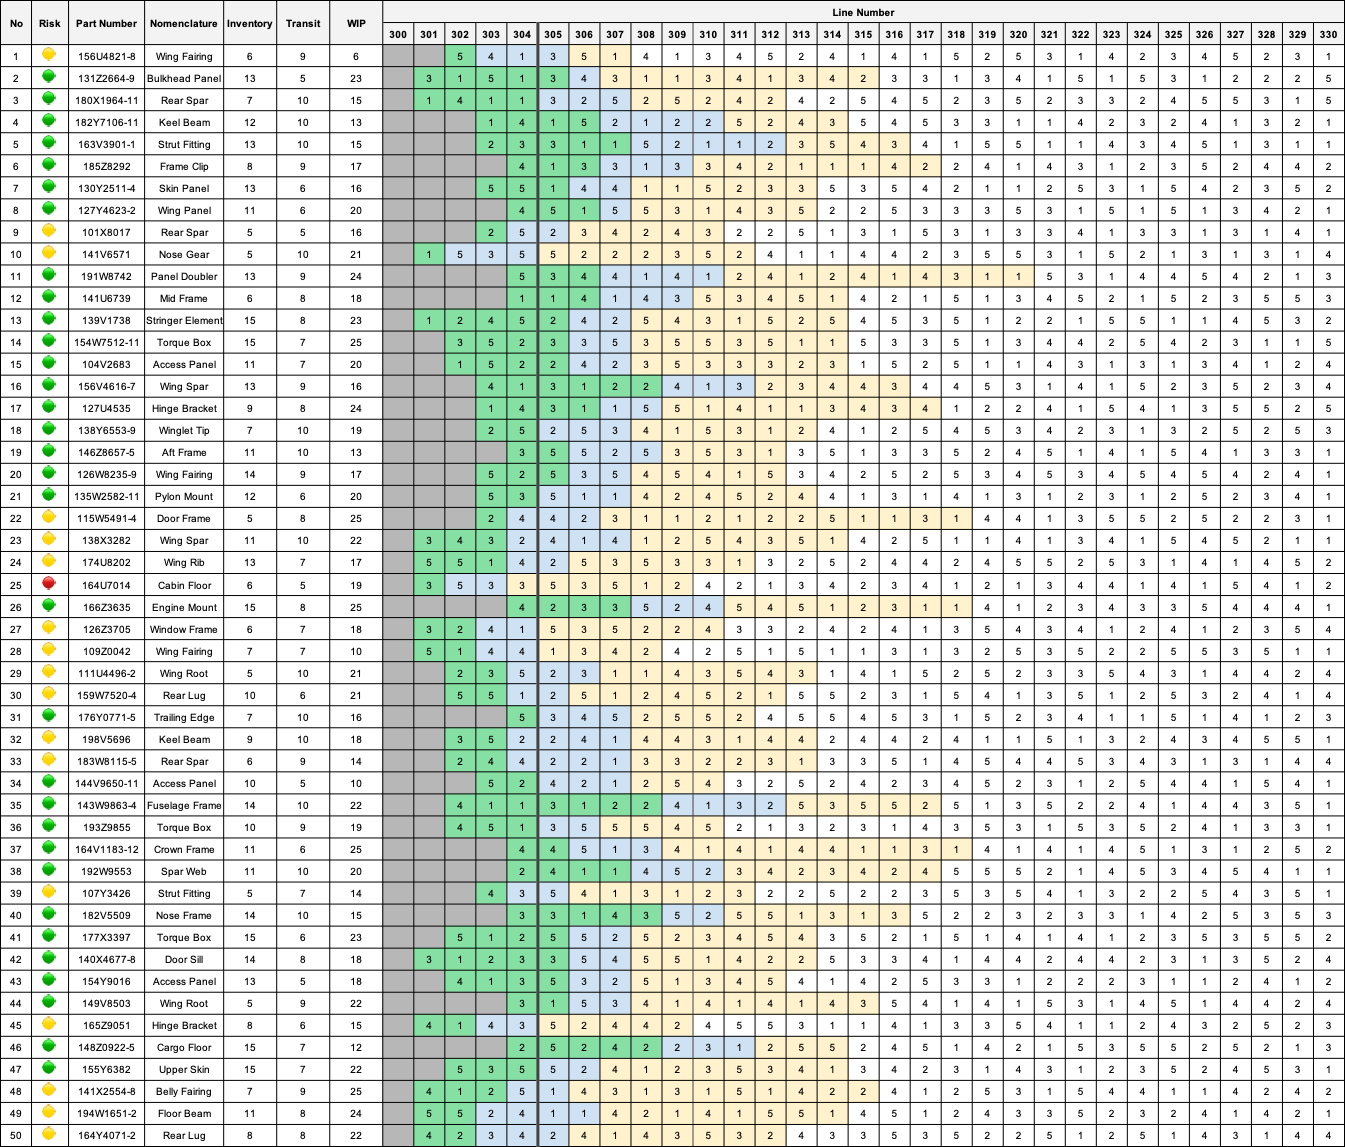

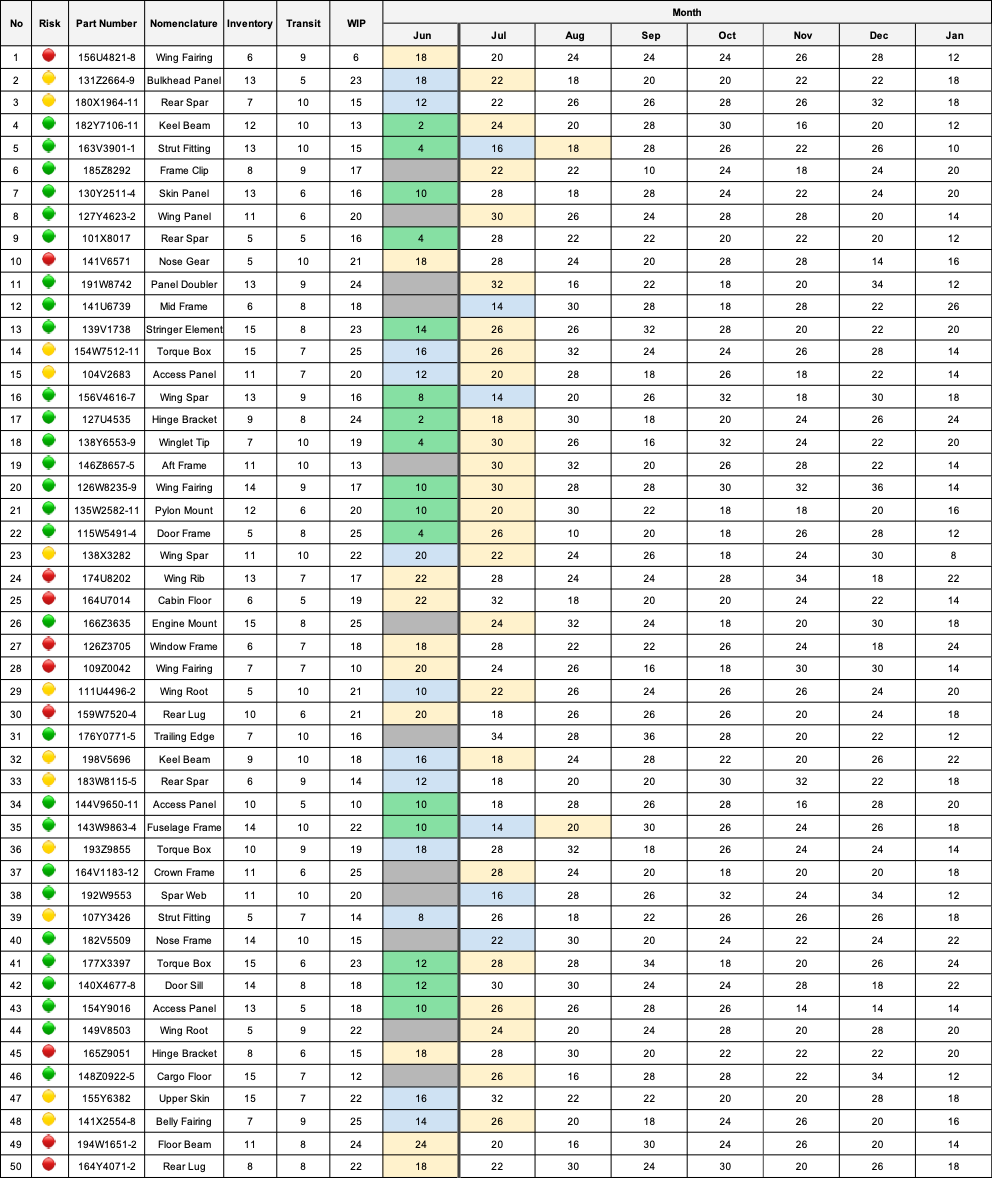

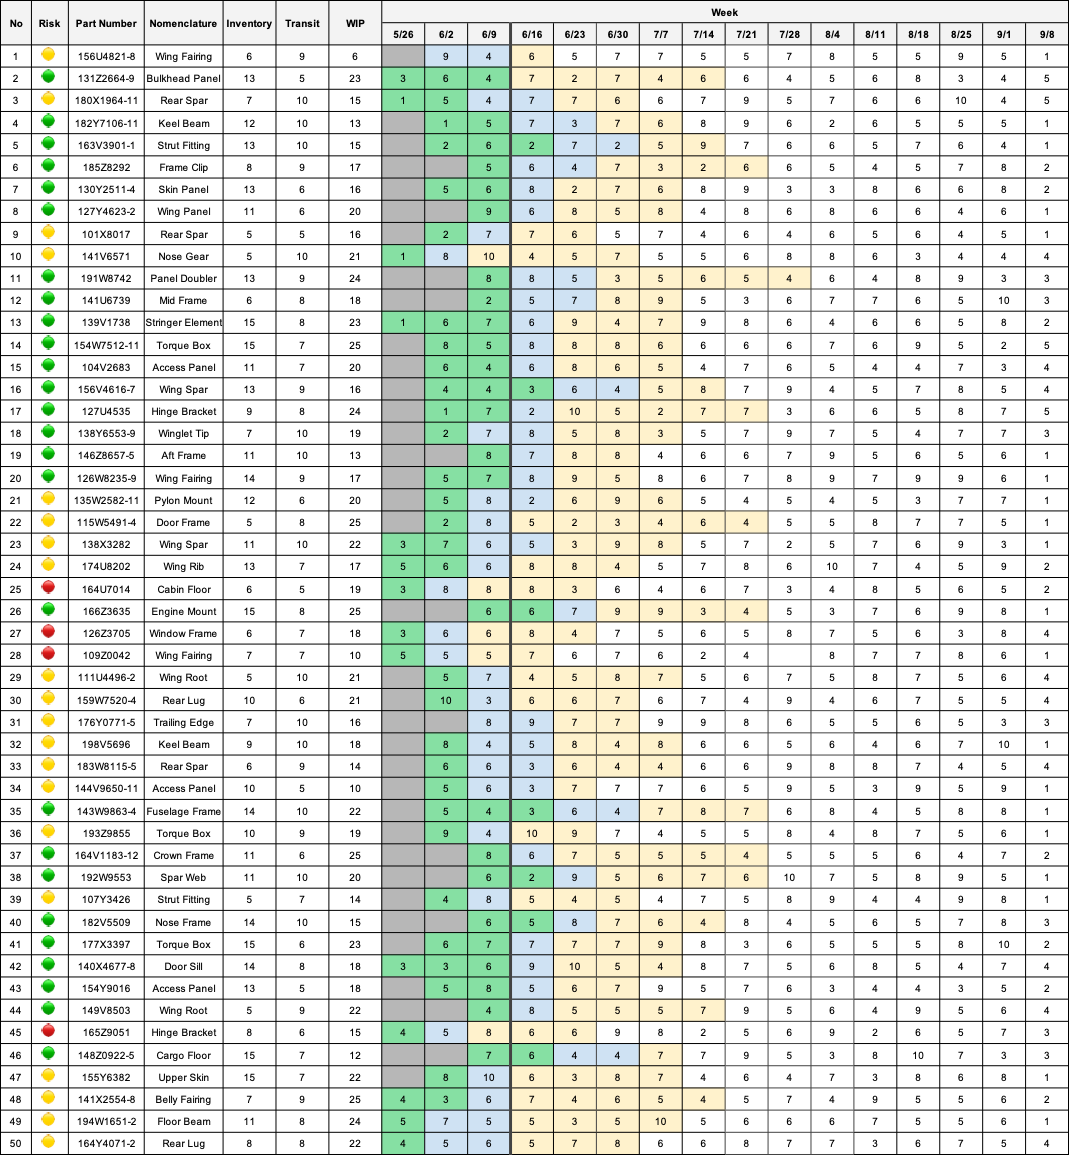

In [15]:
from pathlib import Path
from PIL import Image as PILImage
from IPython.display import Image as IPyImage, display
import io

def show_png_on_white(folder: str, filename: str):
    path = Path(folder) / filename
    img  = PILImage.open(path).convert("RGBA")

    # flatten transparency onto white
    if img.mode == "RGBA":
        white = PILImage.new("RGB", img.size, (255, 255, 255))
        white.paste(img, mask=img.split()[3])
        img = white

    buf = io.BytesIO()
    img.save(buf, format="PNG")
    display(IPyImage(data=buf.getvalue()))

# render each
show_png_on_white("lob_diagrams", "LN.png")
show_png_on_white("lob_diagrams", "Month.png")
show_png_on_white("lob_diagrams", "Week.png")
